In [23]:
# Import related library
import geopandas as gpd
# Importing the Hong Kong 18 districts boundary GeoJSON file
map_data = gpd.read_file("HK/Hong_Kong_18_Districts/Hong_Kong_18_Districts.shp")


In [24]:
# Dropping the unwanted column
map_data.drop("TCNAME", axis = 1, inplace = True)


In [25]:
# Extract data
map_data = map_data.loc[map_data['ENAME'].isin({'CENTRAL & WESTERN', 'WAN CHAI', 'YAU TSIM MONG'})]
# Prepare for the location of label
map_data["center"] = map_data["geometry"].centroid
top3_points = map_data.copy()
top3_points.set_geometry("center", inplace = True)

In [26]:
data = pd.read_csv("HK/top3.csv")
# Dropping out the unwanted columns
data = data.drop({'Unnamed: 0', 'host_id', 'minimum_nights','number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'price'}, axis = 1)

Plot all data points as scatter map:

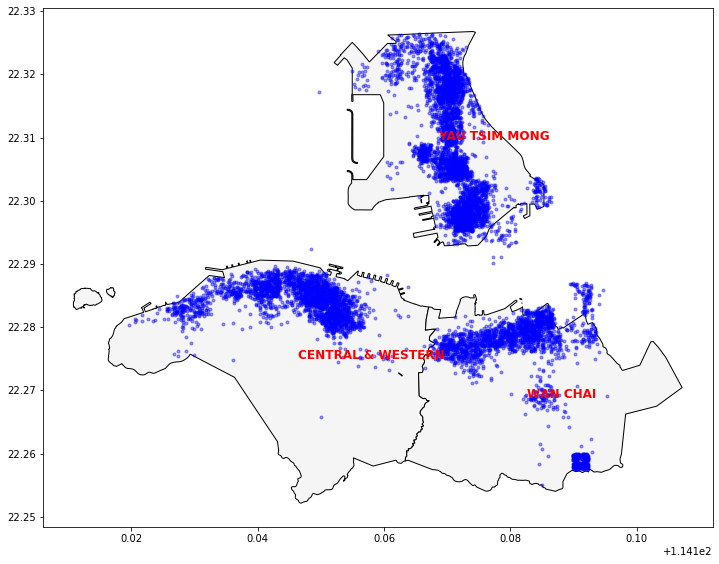

In [27]:
map_top3 = map_data.plot(figsize=(12,10), color = 'whitesmoke', edgecolor='black', linewidth = 1, legend = True)
texts = []
plt.scatter(data['longitude'], data['latitude'], c='blue', marker = '.', alpha = 0.4)
for x, y, label in zip(top3_points.geometry.x, top3_points.geometry.y, top3_points.ENAME):
    texts.append(plt.text(x, y, label, fontsize = 8, size = 12, color = 'red', weight ='bold'))

In [28]:
# import KMeans
from sklearn.cluster import KMeans

In [29]:
# create np array for data points
points = data[['longitude', 'latitude']].to_numpy()
# Create kmeans object
kmeans = KMeans(n_clusters=3)
# Fit kmeans object to data
kmeans.fit(points)
# print location of clusters learn by keams object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(points)

[[114.14645164  22.284201  ]
 [114.171044    22.30801942]
 [114.18202432  22.27517135]]


Time for plotting the result of clustering:

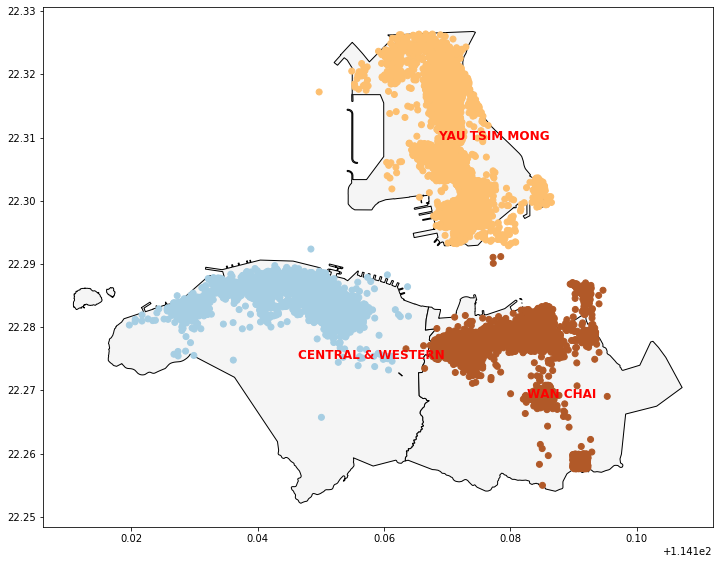

In [30]:
# Define the base map
map_top3 = map_data.plot(figsize=(12,10), color = 'whitesmoke', edgecolor='black', linewidth = 1, legend = True)
texts = []
# Plotting out all points
plt.scatter(points[:,0], points[:,1],c=y_km, cmap='Paired')
# Adding label for each district
for x, y, label in zip(top3_points.geometry.x, top3_points.geometry.y, top3_points.ENAME):
    texts.append(plt.text(x, y, label, fontsize = 8, size = 12, color = 'red', weight ='bold'))

In [34]:
data_yau = data[data.neighbourhood == 'YAU TSIM MONG']
# create np array for data points
points_yau = data_yau[['longitude', 'latitude']].to_numpy()
yau_points = top3_points[top3_points.ENAME == 'YAU TSIM MONG']
# Extract map of YAU TSIM MONG
map_yau = map_data.loc[map_data['ENAME'].isin({'YAU TSIM MONG'})]

In [35]:
tsuen_wan_line = {
	'station':['Tsim Sha Tsui Station', 'Jordan Station', 'Yau Ma Tei Station', 'Mong Kok Station', 'Prince Edward Station'],
        'latitude':[22.297560, 22.3048588, 22.313351, 22.319232, 22.324611],
        'longitude':[114.172209, 114.17172, 114.170572, 114.169349, 114.168269]
}
tsuen_wan_line = pd.DataFrame(tsuen_wan_line)
tsuen_wan_line

,station,latitude,longitude
0,Tsim Sha Tsui Station,22.297560,114.172209
1,Jordan Station,22.304859,114.171720
2,Yau Ma Tei Station,22.313351,114.170572
3,Mong Kok Station,22.319232,114.169349
4,Prince Edward Station,22.324611,114.168269


Since that we don’t know the optimal number of clusters(K) for Yau Tsim Mong, we will create a for loop to plot a series of maps with a range of K, for exploring the best K value.

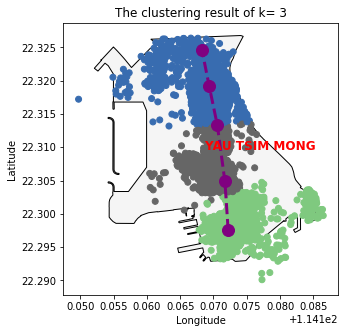

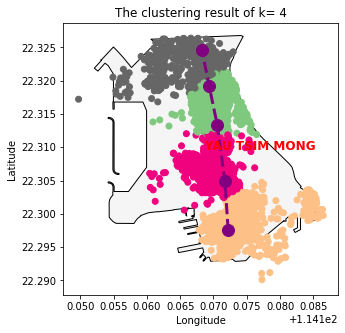

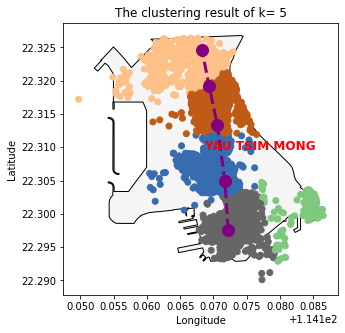

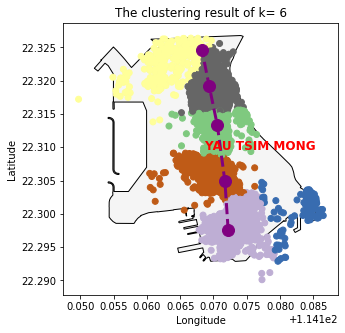

In [36]:
# Define the range of K
K = [3,4,5,6]
for i,k in enumerate(K):
    # Create kmeans object
    kmeans = KMeans(n_clusters=k)
    # Fit kmeans object to data
    kmeans.fit(points_yau)
    # print location of clusters learn by keams object
    #print(kmeans.cluster_centers_)
    # save new clusters for chart
    y_km = kmeans.fit_predict(points_yau)
    
    map_yau.plot(figsize=(6,5), color = 'whitesmoke', edgecolor='black', linewidth = 1, legend = True)
    plt.scatter(points_yau[:,0], points_yau[:,1],c=y_km, cmap='Accent')
    plt.plot(tsuen_wan_line.longitude, tsuen_wan_line.latitude, color='purple', marker='o', linestyle='dashed', linewidth=3, markersize=12)
    for x, y, label in zip(yau_points.geometry.x, yau_points.geometry.y, yau_points.ENAME):
        texts.append(plt.text(x, y, label, fontsize = 8, size = 12, color = 'red', weight ='bold'))
    plt.title("The clustering result of k= " + str(k))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

# DB-Scan Clustering Algorithm

In [38]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
sns.set()

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


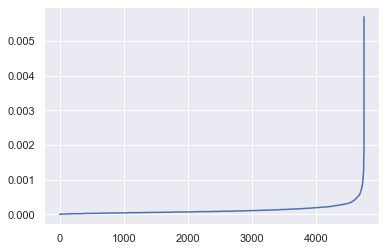

In [39]:
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(points_yau)
distances, indices = nbrs.kneighbors(points_yau)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Based on the k-distance plot, the elbow point of the k-distance plot may be the ideal value of eps, besides, since we are using the latitude and longitude as the clustering features, it is reasonable to use haversine metric and ball tree algorithm to compute the great circle distance between points, this come from the tutorial https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/.

Text(129.63539907106656, 0.5, 'Latitude')

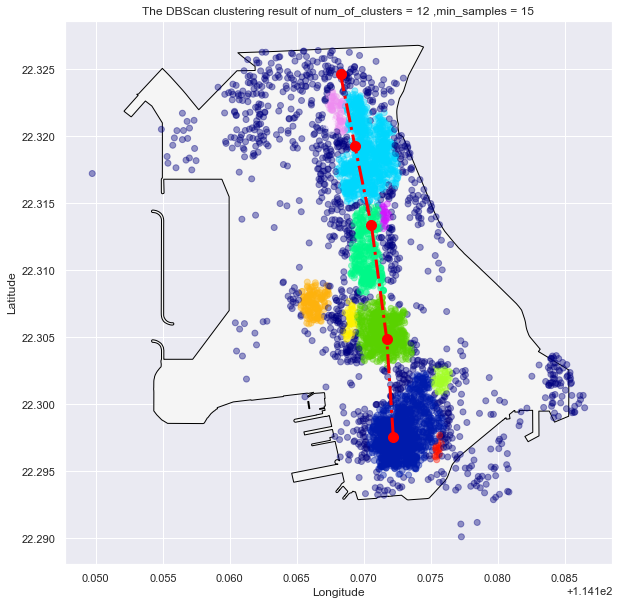

In [41]:
dbscan = DBSCAN(eps=2/6371., min_samples=15, algorithm='ball_tree', metric='haversine')
# Fit kmeans object to data
dbscan.fit(points_yau)
# save new clusters for chart
y_db = dbscan.fit_predict(points_yau)
labels = dbscan.labels_
num_of_clusters = len(set(labels))
    
map_yau.plot(figsize=(12,10), color = 'whitesmoke', edgecolor='black', linewidth = 1, legend = True)
plt.scatter(points_yau[:,0], points_yau[:,1],c=y_db, cmap='gist_ncar', alpha = 0.4)
plt.plot(tsuen_wan_line.longitude, tsuen_wan_line.latitude, color='red', marker='.', linestyle='-.', linewidth=3, markersize=20)
plt.title("The DBScan clustering result of num_of_clusters = " + str(num_of_clusters) + ' ,min_samples = 15')
plt.xlabel("Longitude")
plt.ylabel("Latitude")